In [3]:
# colab
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

import os
fname = os.path.join('jena_climate_2009_2016.csv')

--2022-11-14 14:52:42--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.26.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.26.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.24MB/s    in 2.5s    

2022-11-14 14:52:46 (5.24 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [4]:
# import os
# data_dir = './datasets/jena_climate/'
# fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv'

In [5]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

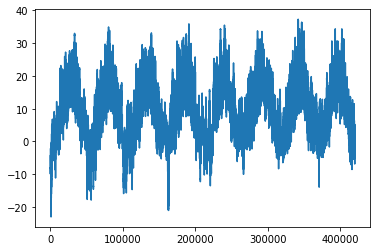

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

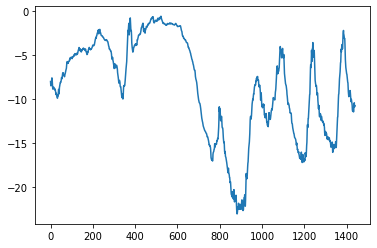

In [8]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
# TODO dataset01
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:
# TODO dataset02
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [13]:
for samples, targets in train_dataset:
    print("sample shape:", samples.shape)
    print("target shape:", targets.shape)
    break

sample shape: (256, 120, 14)
target shape: (256,)


- 상식 수준의 기준점

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


- 기본적인 머신 러닝 모델 시도 해보기

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 54ms/step - loss: 12.8099 - mae: 2.7553 - val_loss: 10.5682 - val_mae: 2.5725
Epoch 2/10
819/819 [==============================] - 37s 44ms/step - loss: 9.0220 - mae: 2.3620 - val_loss: 11.5155 - val_mae: 2.6889
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.3237 - mae: 2.2740 - val_loss: 10.2807 - val_mae: 2.5389
Epoch 4/10
819/819 [==============================] - 37s 45ms/step - loss: 7.9483 - mae: 2.2233 - val_loss: 10.3011 - val_mae: 2.5492
Epoch 5/10
819/819 [==============================] - 37s 44ms/step - loss: 7.6294 - mae: 2.1815 - val_loss: 10.6512 - val_mae: 2.5856
Epoch 6/10
819/819 [==============================] - 37s 44ms/step - loss: 7.3908 - mae: 2.1475 - val_loss: 10.2934 - val_mae: 2.5400
Epoch 7/10
819/819 [==============================] - 37s 44ms/step - loss: 7.2141 - mae: 2.1235 - val_loss: 11.6890 - val_mae: 2.7027
Epoch 8/10
819/819 [==============================] - 

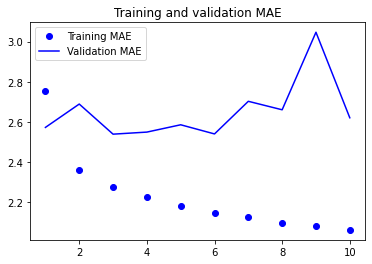

In [16]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 50ms/step - loss: 30.3205 - mae: 4.1741 - val_loss: 16.9300 - val_mae: 3.2206
Epoch 2/10
819/819 [==============================] - 38s 47ms/step - loss: 16.4751 - mae: 3.2162 - val_loss: 22.8270 - val_mae: 3.8399
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 15.0566 - mae: 3.0723 - val_loss: 15.1965 - val_mae: 3.0932
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 14.2859 - mae: 2.9932 - val_loss: 15.6713 - val_mae: 3.1102
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 13.5981 - mae: 2.9193 - val_loss: 16.8500 - val_mae: 3.2357
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 13.0609 - mae: 2.8618 - val_loss: 14.0771 - val_mae: 2.9531
Epoch 7/10
819/819 [==============================] - 38s 47ms/step - loss: 12.6250 - mae: 2.8133 - val_loss: 14.4068 - val_mae: 2.9850
Epoch 8/10
819/819 [============================

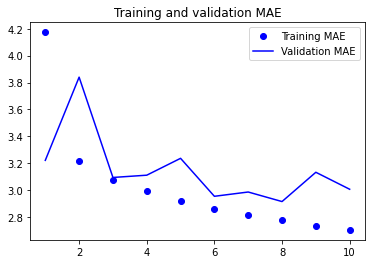

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
# TODO LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 50ms/step - loss: 42.4489 - mae: 4.7612 - val_loss: 12.7521 - val_mae: 2.7154
Epoch 2/10
819/819 [==============================] - 41s 49ms/step - loss: 10.7069 - mae: 2.5381 - val_loss: 9.3472 - val_mae: 2.3562
Epoch 3/10
819/819 [==============================] - 41s 49ms/step - loss: 9.2398 - mae: 2.3719 - val_loss: 9.3036 - val_mae: 2.3552
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 8.6138 - mae: 2.2951 - val_loss: 9.1450 - val_mae: 2.3466
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 8.2320 - mae: 2.2450 - val_loss: 9.1504 - val_mae: 2.3499
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 7.9650 - mae: 2.2086 - val_loss: 9.0296 - val_mae: 2.3463
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 7.7649 - mae: 2.1777 - val_loss: 9.0543 - val_mae: 2.3544
Epoch 8/10
819/819 [==============================] - 41s 5

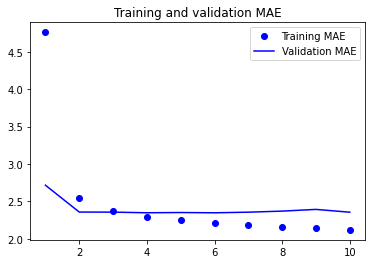

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()